In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/offense-language-detection/DATASET/test_labels.csv
/kaggle/input/offense-language-detection/DATASET/validation.csv
/kaggle/input/offense-language-detection/DATASET/train.csv
/kaggle/input/offense-language-detection/DATASET/test.csv


In [2]:
import os

os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
! pip install -q scikit-multilearn
! pip install -q transformers
! pip install -q tensorflow-text
! pip install -q tf-models-official
! pip install deep_translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

In [4]:
### Imports ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

In [5]:
### Style settings ###
plt.style.use('ggplot')
sns.set_palette("Set2")

# **Step 1: Exploratory Data Analysis (EDA)**

In [6]:
### Read data ###
train_df = pd.read_csv("/kaggle/input/offense-language-detection/DATASET/train.csv")
test_df = pd.read_csv("/kaggle/input/offense-language-detection/DATASET/test.csv")
val_df = pd.read_csv("/kaggle/input/offense-language-detection/DATASET/validation.csv") 

In [7]:
train_df.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


### ***Visualize Label Distribution Across Toxicity Types***

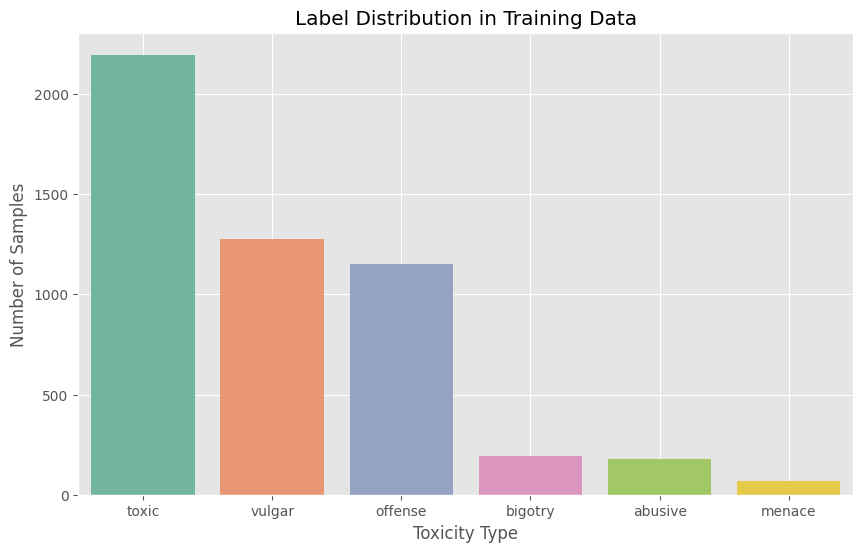

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']

# Plot count of each label
label_counts = train_df[labels].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution in Training Data")
plt.ylabel("Number of Samples")
plt.xlabel("Toxicity Type")
plt.grid(True)
plt.show()

### ***Class Imbalance Analysis***

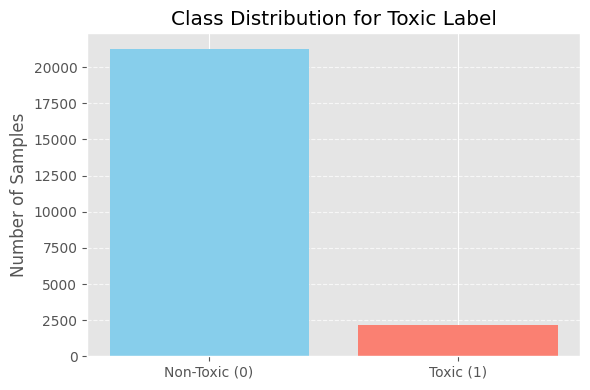

In [9]:
# Count values for 'toxic' column
class_counts = train_df['toxic'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Non-Toxic (0)', 'Toxic (1)'], class_counts.values, color=['skyblue', 'salmon'])
plt.title('Class Distribution for Toxic Label')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### ***Analyze Sentence Structure (Length, Word Distribution, Common Words)***

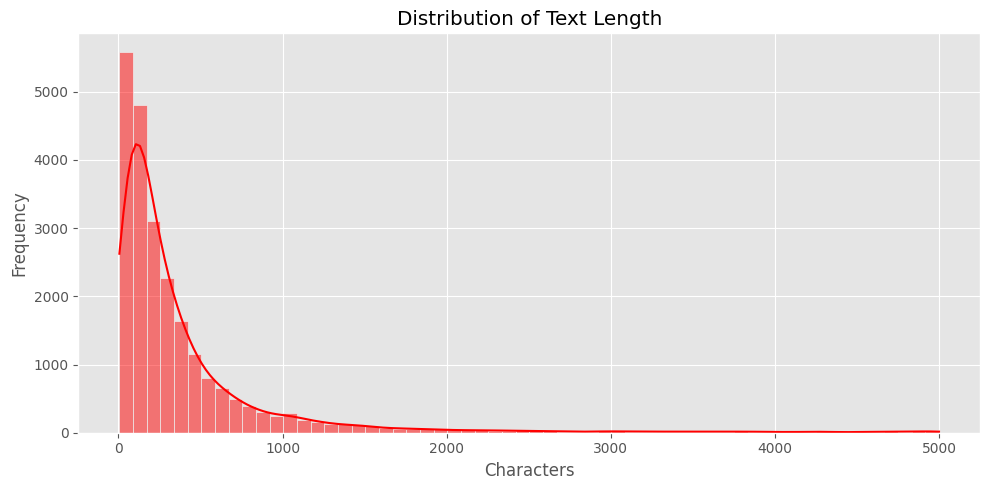

In [10]:
# Add sentence length column
train_df['text_length'] = train_df['feedback_text'].astype(str).apply(len)

# Sentence Length Distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_df['text_length'], bins=60, kde=True, color='red')
plt.title('Distribution of Text Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

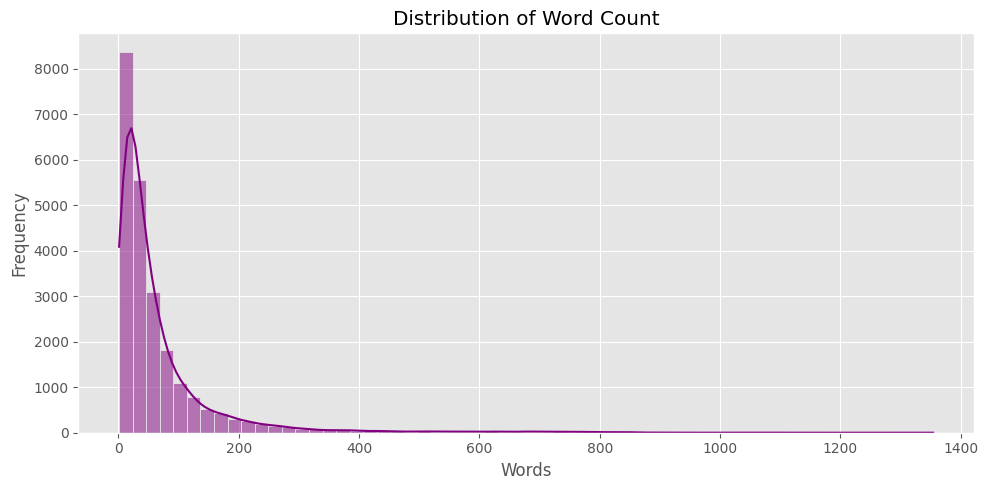

In [11]:
train_df['word_count'] = train_df['feedback_text'].astype(str).apply(lambda x: len(x.split()))

# Word Count Distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_df['word_count'], bins=60, kde=True, color='purple')
plt.title('Distribution of Word Count')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


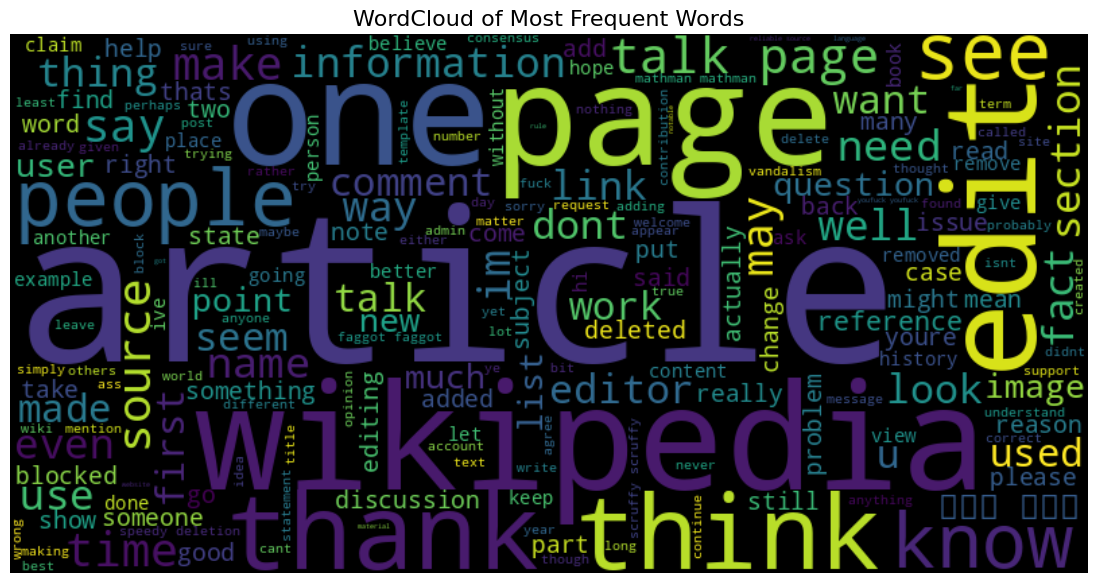

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string

# Download stopwords from nltk
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))

wordcloud_stopwords = set(STOPWORDS)
combined_stopwords = nltk_stopwords.union(wordcloud_stopwords)

all_text = ' '.join(train_df['feedback_text'].astype(str)).lower()

# Remove punctuation manually for better results
all_text = all_text.translate(str.maketrans('', '', string.punctuation))

wordcloud = WordCloud(width=800, height=400,
                      stopwords=combined_stopwords,
                      colormap='viridis',  # Gradient color map
                      max_words=200).generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Most Frequent Words", fontsize=16)
plt.show()

### ***Check for missing values or outliers***

In [13]:
print("Missing values in each column:\n")
print(train_df.isnull().sum())

Missing values in each column:

id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
text_length      0
word_count       0
dtype: int64


In [14]:
train_df.dropna(subset=['feedback_text'], inplace=True)

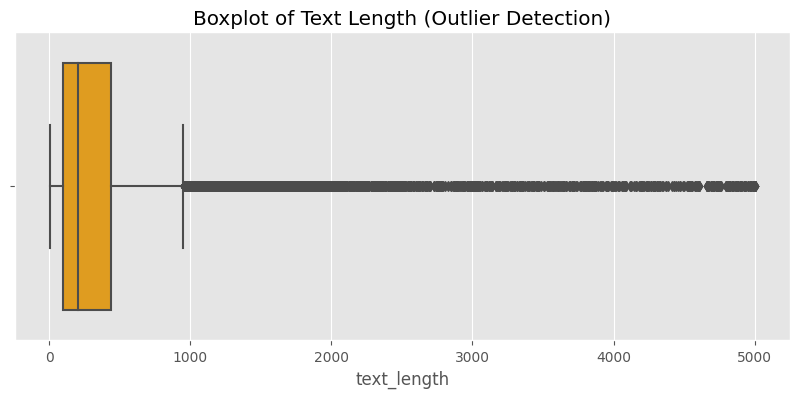

In [15]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=train_df['text_length'], color='orange')
plt.title('Boxplot of Text Length (Outlier Detection)')
plt.show()

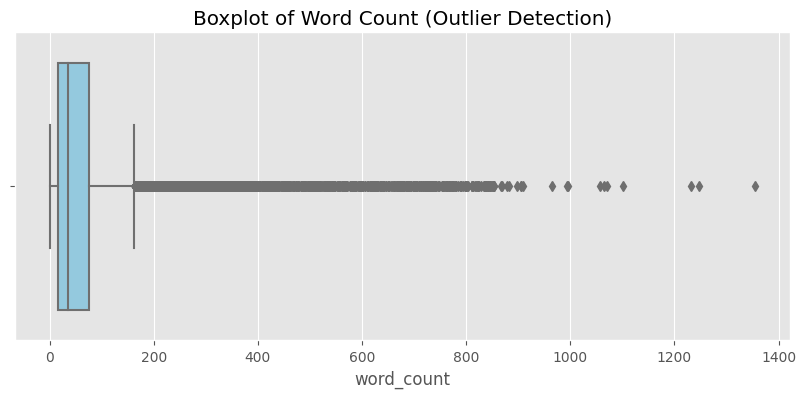

In [16]:
# Calculate word count if not already present
train_df['word_count'] = train_df['feedback_text'].apply(lambda x: len(str(x).split()))

# Plot boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=train_df['word_count'], color='skyblue')
plt.title('Boxplot of Word Count (Outlier Detection)')
plt.show()

In [17]:
# Text Length thresholds
len_low, len_high = train_df['text_length'].quantile([0.01, 0.99])

# Word Count thresholds
word_low, word_high = train_df['word_count'].quantile([0.01, 0.99])

outliers = train_df[
    (train_df['text_length'] < len_low) | (train_df['text_length'] > len_high) |
    (train_df['word_count'] < word_low) | (train_df['word_count'] > word_high)
]

print(f"Total samples: {len(train_df)}")
print(f"Outliers detected: {len(outliers)}")
print(f"Outlier percentage: {100 * len(outliers)/len(train_df):.2f}%")

Total samples: 23473
Outliers detected: 504
Outlier percentage: 2.15%


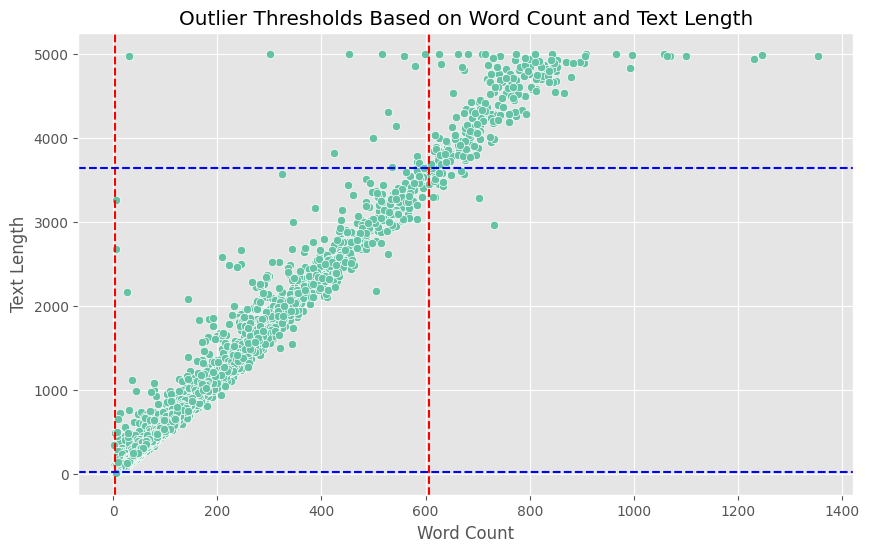

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='word_count', y='text_length')
plt.axvline(word_low, color='red', linestyle='--')
plt.axvline(word_high, color='red', linestyle='--')
plt.axhline(len_low, color='blue', linestyle='--')
plt.axhline(len_high, color='blue', linestyle='--')
plt.title('Outlier Thresholds Based on Word Count and Text Length')
plt.xlabel('Word Count')
plt.ylabel('Text Length')
plt.grid(True)
plt.show()

# **Step 2: Text Preprocessing**

### ***Tokenization, Stemming/Lemmatization, Lowercasing, Removing Stop Words, Special haracters, and Punctuation***

In [19]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from deep_translator import GoogleTranslator

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Apply translation if text is not in English
def translate_to_english(text, lang):
    if lang != 'en':
        try:
            return GoogleTranslator(source=lang, target='en').translate(text)
        except Exception as e:
            print(f"[Translation failed] Using original: {text[:50]}... | Reason: {e}")
            return text  
    else:
        return text

# Tokenization, Lowercasing, Removing stop words, special characters, punctuation
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove special characters, digits, and punctuation using regex
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra spaces (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in combined_stopwords]

    return tokens

# Stemming and Lemmatization
def apply_stemming(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokens]

def apply_lemmatization(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

# Example text preprocessing function
def text_preprocessing(text, use_stemming=True):

    tokens = preprocess_text(text)
    
    if use_stemming:
        return apply_stemming(tokens)
    else:
        return apply_lemmatization(tokens)

# Example of preprocessing a single text
example_text = train_df['feedback_text'][0]

preprocessed_text = text_preprocessing(example_text, use_stemming=True)
print(preprocessed_text)

['sound', 'good', 'let', 'know', 'your', 'done', 'ill', 'start', 'pr']


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### ***Feature Extraction using TF-IDF***

In [20]:
# Feature Extraction: TF-IDF Vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Converting text to numeric vectors
def tfidf_feature_extraction(text_data, vectorizer=None):
    if vectorizer is None:
        # Fit a new vectorizer on training data
        vectorizer = TfidfVectorizer(max_features=5000, min_df=3)
        tfidf_matrix = vectorizer.fit_transform(text_data)
    else:
        # Use the existing vectorizer for test data
        tfidf_matrix = vectorizer.transform(text_data)
    return tfidf_matrix, vectorizer


train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 1)

# Preprocess all text in the DataFrame
train_df['processed_text'] = train_df['feedback_text'].apply(text_preprocessing)
val_df['processed_text'] = val_df['feedback_text'].apply(text_preprocessing)
test_df['processed_text'] = test_df['content'].apply(text_preprocessing)

# Join the tokens back into a string for TF-IDF vectorization
train_df['processed_text'] = train_df['processed_text'].apply(lambda x: ' '.join(x))
val_df['processed_text'] = train_df['processed_text'].apply(lambda x: ' '.join(x))
test_df['processed_text'] = test_df['processed_text'].apply(lambda x: ' '.join(x))

# Extract TF-IDF features
X_train_tfidf, tfidf_vectorizer = tfidf_feature_extraction(train_df['processed_text'])
X_test_tfidf, _ = tfidf_feature_extraction(test_df['processed_text'], tfidf_vectorizer)  

# Print out the results
print("TF-IDF Matrix Shape:", X_train_tfidf.shape)
print("Sample TF-IDF Feature Names:", tfidf_vectorizer.get_feature_names_out()[:100])

TF-IDF Matrix Shape: (18778, 5000)
Sample TF-IDF Feature Names: ['aa' 'abandon' 'abbrevi' 'abc' 'abid' 'abil' 'abl' 'abort' 'abraham'
 'absenc' 'absolut' 'abstract' 'absurd' 'abund' 'abus' 'ac' 'academ'
 'academi' 'acceler' 'accent' 'accept' 'access' 'accid' 'accident'
 'accompani' 'accomplish' 'accord' 'accordingli' 'account' 'accredit'
 'accur' 'accuraci' 'accus' 'ace' 'achiev' 'acid' 'acknowledg' 'acquir'
 'acronym' 'across' 'act' 'action' 'activ' 'activist' 'actor' 'actress'
 'actual' 'ad' 'adam' 'adapt' 'add' 'addict' 'addit' 'address' 'adequ'
 'adher' 'adject' 'adjust' 'admin' 'administ' 'administr' 'adminship'
 'admir' 'admiss' 'admit' 'admittedli' 'adolesc' 'adolf' 'adopt' 'adult'
 'advanc' 'advantag' 'adventur' 'advert' 'advertis' 'advic' 'advis'
 'advoc' 'advocaci' 'ae' 'aesthet' 'afc' 'afd' 'affair' 'affect' 'affili'
 'affirm' 'afford' 'afghan' 'afghanistan' 'afraid' 'africa' 'african'
 'aftermath' 'afternoon' 'afterward' 'age' 'agenc' 'agenda' 'agent']


# **Step 3: Model Creation**

### ***Evaluation Function***

In [21]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(y_test, y_pred, y_proba):
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")
    print(f"Confusion Matrix:\n, {confusion_matrix(y_test, y_pred)}\n")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
test_labels = pd.read_csv('/kaggle/input/offense-language-detection/DATASET/test_labels.csv')

y_train = train_df[labels]
y_val = val_df[labels]
y_test = test_labels['toxic']

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(18778, 6)
(4695, 6)
(6000,)


## ***Transformer-Based Models***

In [23]:
import tensorflow as tf
import tensorflow_text as text
from official.nlp import optimization 
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model
import pandas as pd
import re

2025-04-13 01:37:55.770699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744508275.790113      19 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744508275.797773      19 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744508275.818254      19 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744508275.818275      19 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744508275.818278      19 computation_placer.cc:177] computation placer alr

### ***Cleaning Texts and Translating Text into English***

In [24]:
nltk.download('punkt')

# Define a simple cleaning function
def clean_text(text, lang='en'):
    text = translate_to_english(text, lang)
    text = text.lower()                  # lowercase
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove digits
    text = text.strip()                  # remove leading/trailing whitespace
    text = re.sub(r'\s+', ' ', text)     # remove extra spaces
    return text

# Apply to train, val and test data
train_text = train_df['feedback_text'].apply(clean_text)
val_text = val_df['feedback_text'].apply(clean_text)
test_text = test_df.apply(lambda row: clean_text(row['content'], row['lang']), axis=1)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
# Preparaing the data to feed into the model
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_text.values, y_train.values)).shuffle(50000).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_text.values, y_val.values)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_text.values, y_test.values)).batch(batch_size)

I0000 00:00:1744508684.167539      19 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## ***BERT***

In [26]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf

# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'  
tokenizer = BertTokenizer.from_pretrained(model_name)
bert = TFBertModel.from_pretrained(model_name)

def build_model():
    # Text input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    # Custom preprocessing layer
    def preprocessing(text):
        # Convert tensor to list of strings
        text_list = [x.decode('utf-8') for x in text.numpy()]
        # Tokenize with same settings as TF Hub preprocessor
        tokenized = tokenizer(
            text_list,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors="tf"
        )
        return tokenized.input_ids, tokenized.token_type_ids, tokenized.attention_mask
    
    # Wrapper for preprocessing
    def preprocessing_wrapper(text):
        input_ids, token_type_ids, attention_mask = tf.py_function(
            preprocessing,
            [text],
            (tf.int32, tf.int32, tf.int32)
        )
        # Set shapes to match TF Hub output
        input_ids.set_shape([None, 128])
        token_type_ids.set_shape([None, 128])
        attention_mask.set_shape([None, 128])
        return {'input_word_ids': input_ids, 
                'input_type_ids': token_type_ids, 
                'input_mask': attention_mask}
    
    # Preprocessing layer 
    preprocessing_layer = tf.keras.layers.Lambda(
        preprocessing_wrapper, 
        name='preprocessing'
    )(text_input)

    bert.trainable = True
    
    # BERT encoder 
    encoder_outputs = bert(
        input_ids=preprocessing_layer['input_word_ids'],
        attention_mask=preprocessing_layer['input_mask'],
        token_type_ids=preprocessing_layer['input_type_ids'],
        training=True 
    )
    
    # Get pooled output
    pooled_output = encoder_outputs.pooler_output
    
    x = tf.keras.layers.Dropout(0.3)(pooled_output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(6, activation='sigmoid')(x)

    return tf.keras.Model(inputs=text_input, outputs=output)

# Build and show summary
model = build_model()
model.summary()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (Lambda)      {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [27]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.metrics.BinaryAccuracy(), tf.metrics.AUC(multi_label=True)]

In [28]:
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [29]:
# compile the model
model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=metrics)

In [30]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

In [31]:
# train the model
bert_history = model.fit(train_ds, 
                       validation_data=val_ds, 
                       epochs = epochs, 
                       callbacks = callbacks)

Epoch 1/20
587/587 [==============================] - 368s 577ms/step - loss: 0.2306 - binary_accuracy: 0.8968 - auc: 0.7463 - val_loss: 0.0553 - val_binary_accuracy: 0.9811 - val_auc: 0.9543
Epoch 2/20
587/587 [==============================] - 333s 566ms/step - loss: 0.0603 - binary_accuracy: 0.9791 - auc: 0.9471 - val_loss: 0.0541 - val_binary_accuracy: 0.9797 - val_auc: 0.9645
Epoch 3/20
587/587 [==============================] - 332s 565ms/step - loss: 0.0477 - binary_accuracy: 0.9828 - auc: 0.9679 - val_loss: 0.0548 - val_binary_accuracy: 0.9799 - val_auc: 0.9756
Epoch 4/20
587/587 [==============================] - 333s 567ms/step - loss: 0.0367 - binary_accuracy: 0.9866 - auc: 0.9782 - val_loss: 0.0529 - val_binary_accuracy: 0.9810 - val_auc: 0.9664
Epoch 5/20
587/587 [==============================] - 333s 567ms/step - loss: 0.0293 - binary_accuracy: 0.9895 - auc: 0.9842 - val_loss: 0.0644 - val_binary_accuracy: 0.9813 - val_auc: 0.9532
Epoch 6/20
587/587 [====================

### ***Model Evaluation on Validation Set***

In [32]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy, val_auc = model.evaluate(val_ds)

print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation AUC: {val_auc}')

147/147 [==============================] - 31s 214ms/step - loss: 0.0536 - binary_accuracy: 0.9807 - auc: 0.9630
Validation Loss: 0.053594838827848434
Validation Accuracy: 0.9806531667709351
Validation AUC: 0.9629507660865784


147/147 [==============================] - 36s 211ms/step

Best Threshold: 0.6000000000000001
Best F1 Score: 0.7486
Accuracy: 0.9534
Precision: 0.7443
Recall: 0.7529
F1 Score: 0.7486
ROC AUC: 0.9670

Confusion Matrix:
, [[4150  112]
 [ 107  326]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4262
           1       0.74      0.75      0.75       433

    accuracy                           0.95      4695
   macro avg       0.86      0.86      0.86      4695
weighted avg       0.95      0.95      0.95      4695



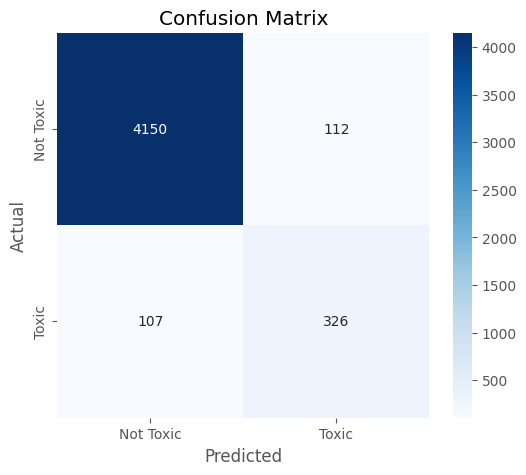

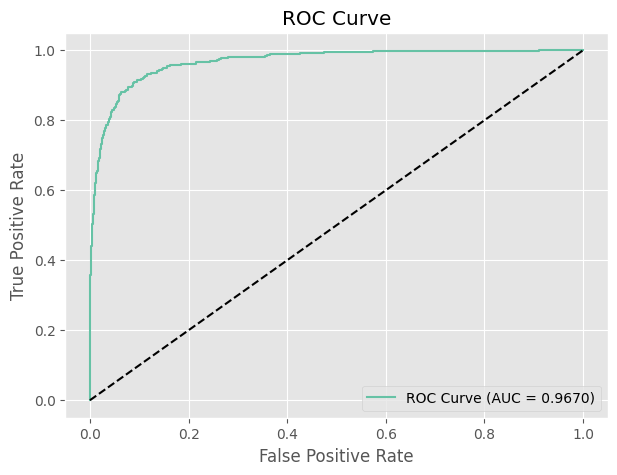

In [33]:
# Predict probabilities
y_proba = model.predict(val_ds)[:, 0]  # get the toxic column only (index 0)

# True labels (toxic column only)
y_true = y_val['toxic'].values

# Using different thresholds to find the best one
thresholds = [i * 0.05 for i in range(1, 21)]  # 0.05 to 1.0
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    
    # Computing F1 separately to select best threshold
    f1 = f1_score(y_true, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1:.4f}")

# Final prediction using best threshold
y_pred = (y_proba >= best_threshold).astype(int)

evaluate_model(y_true, y_pred, y_proba)

### ***Model Evaluation on Test Set***

188/188 [==============================] - 44s 209ms/step

Best Threshold: 0.05
Best F1 Score: 0.6089

Accuracy: 0.8337
Precision: 0.6535
Recall: 0.5701
F1 Score: 0.6089
ROC AUC: 0.8723

Confusion Matrix:
, [[4225  412]
 [ 586  777]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      4637
           1       0.65      0.57      0.61      1363

    accuracy                           0.83      6000
   macro avg       0.77      0.74      0.75      6000
weighted avg       0.83      0.83      0.83      6000



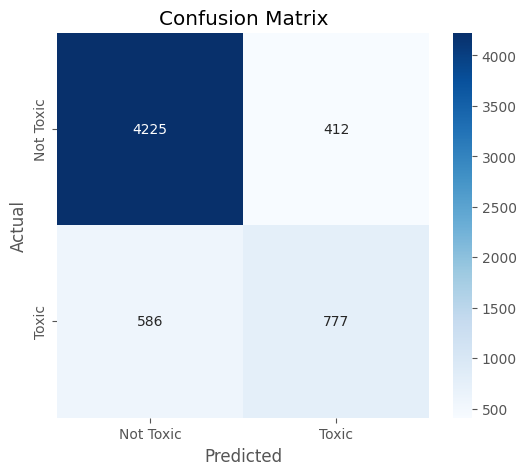

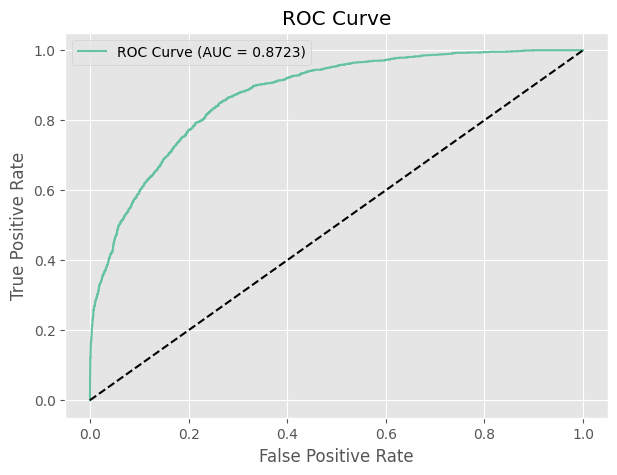

In [34]:
# Predict probabilities
y_proba = model.predict(test_ds)[:, 0]  # get the toxic column only (index 0)

# True labels (toxic column only)
y_true = y_test.values

# Using different thresholds to find the best one
thresholds = [i * 0.05 for i in range(1, 21)]  # 0.05 to 1.0
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    
    # Computing F1 separately to select best threshold
    f1 = f1_score(y_true, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1:.4f}\n")

# Final prediction using best threshold
y_pred = (y_proba >= best_threshold).astype(int)

evaluate_model(y_true, y_pred, y_proba)

## ***XLM-RoBERTa***

In [35]:
from transformers import TFXLMRobertaModel, XLMRobertaTokenizer
import tensorflow as tf

# Load pre-trained model and tokenizer
model_name = 'xlm-roberta-base'  # Using XLM-RoBERTa base model
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
xlm_roberta = TFXLMRobertaModel.from_pretrained(model_name)

def build_model():
    # Text input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    # Custom preprocessing layer
    def preprocessing(text):
        # Convert tensor to list of strings
        text_list = [x.decode('utf-8') for x in text.numpy()]
        # Tokenize with same settings as TF Hub preprocessor
        tokenized = tokenizer(
            text_list,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors="tf"
        )
        return tokenized.input_ids, tokenized.token_type_ids, tokenized.attention_mask
    
    # Wrapper for preprocessing
    def preprocessing_wrapper(text):
        input_ids, token_type_ids, attention_mask = tf.py_function(
            preprocessing,
            [text],
            (tf.int32, tf.int32, tf.int32)
        )
        # Set shapes to match XLM-RoBERTa output
        input_ids.set_shape([None, 128])
        token_type_ids.set_shape([None, 128])
        attention_mask.set_shape([None, 128])
        return {'input_ids': input_ids, 
                'token_type_ids': token_type_ids, 
                'attention_mask': attention_mask}
    
    # Preprocessing layer 
    preprocessing_layer = tf.keras.layers.Lambda(
        preprocessing_wrapper, 
        name='preprocessing'
    )(text_input)

    xlm_roberta.trainable = True
    
    # XLM-RoBERTa encoder 
    encoder_outputs = xlm_roberta(
        input_ids=preprocessing_layer['input_ids'],
        attention_mask=preprocessing_layer['attention_mask'],
        token_type_ids=preprocessing_layer['token_type_ids'],
        training=True 
    )
    
    # Get pooled output
    pooled_output = encoder_outputs.pooler_output
    
    x = tf.keras.layers.Dropout(0.3)(pooled_output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(6, activation='sigmoid')(x)

    return tf.keras.Model(inputs=text_input, outputs=output)

# Build and show summary
model = build_model()
model.summary()

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (Lambda)      {'input_ids': (None, 128),   0         ['text[0][0]']                
                              'token_type_ids': (None,                                            
                             128),                                                                
                              'attention_mask': (None,                                            
                             128)}                                                                
                                                                                            

In [36]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.metrics.BinaryAccuracy(), tf.metrics.AUC(multi_label=True)]

In [37]:
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [38]:
# compile the model
model.compile(optimizer= optimizer, 
              loss=loss, 
              metrics=metrics)

In [39]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

In [40]:
# train the model
xlm_history = model.fit(train_ds, 
                       validation_data=val_ds, 
                       epochs = epochs, 
                       callbacks = callbacks)

Epoch 1/20
587/587 [==============================] - 378s 598ms/step - loss: 0.2249 - binary_accuracy: 0.9112 - auc_1: 0.7160 - val_loss: 0.0647 - val_binary_accuracy: 0.9782 - val_auc_1: 0.9436
Epoch 2/20
587/587 [==============================] - 343s 585ms/step - loss: 0.0712 - binary_accuracy: 0.9760 - auc_1: 0.9298 - val_loss: 0.0581 - val_binary_accuracy: 0.9778 - val_auc_1: 0.9585
Epoch 3/20
587/587 [==============================] - 343s 585ms/step - loss: 0.0584 - binary_accuracy: 0.9793 - auc_1: 0.9529 - val_loss: 0.0557 - val_binary_accuracy: 0.9792 - val_auc_1: 0.9515
Epoch 4/20
587/587 [==============================] - 342s 583ms/step - loss: 0.0510 - binary_accuracy: 0.9819 - auc_1: 0.9562 - val_loss: 0.0609 - val_binary_accuracy: 0.9792 - val_auc_1: 0.9427
Epoch 5/20
587/587 [==============================] - 342s 583ms/step - loss: 0.0445 - binary_accuracy: 0.9834 - auc_1: 0.9675 - val_loss: 0.0603 - val_binary_accuracy: 0.9770 - val_auc_1: 0.9591
Epoch 6/20
587/587 [

### ***Model Evaluation on Validation Set***

In [41]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy, val_auc = model.evaluate(val_ds)

print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation AUC: {val_auc}')

147/147 [==============================] - 28s 190ms/step - loss: 0.0538 - binary_accuracy: 0.9806 - auc_1: 0.9535
Validation Loss: 0.053791534155607224
Validation Accuracy: 0.9806177020072937
Validation AUC: 0.9534990191459656


147/147 [==============================] - 33s 186ms/step

Best Threshold: 0.35000000000000003
Best F1 Score: 0.7445
Accuracy: 0.9529
Precision: 0.7454
Recall: 0.7436
F1 Score: 0.7445
ROC AUC: 0.9616

Confusion Matrix:
, [[4152  110]
 [ 111  322]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4262
           1       0.75      0.74      0.74       433

    accuracy                           0.95      4695
   macro avg       0.86      0.86      0.86      4695
weighted avg       0.95      0.95      0.95      4695



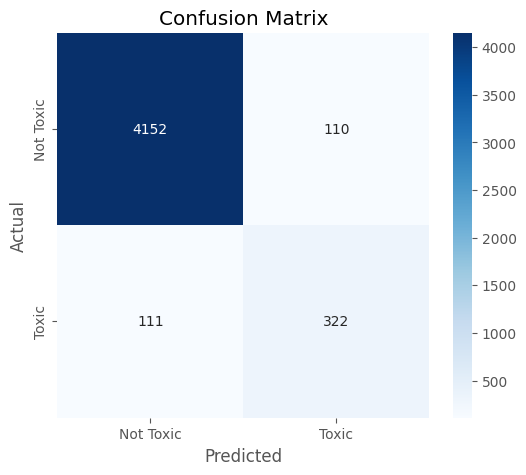

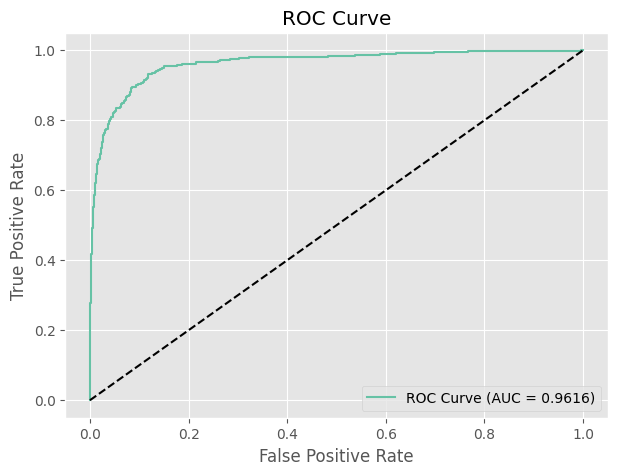

In [42]:
# Predict probabilities
y_proba = model.predict(val_ds)[:, 0]  # get the toxic column only (index 0)

# True labels (toxic column only)
y_true = y_val['toxic'].values

# Using different thresholds to find the best one
thresholds = [i * 0.05 for i in range(1, 21)]  # 0.05 to 1.0
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    
    # Computing F1 separately to select best threshold
    f1 = f1_score(y_true, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1:.4f}")

# Final prediction using best threshold
y_pred = (y_proba >= best_threshold).astype(int)

evaluate_model(y_true, y_pred, y_proba)

### ***Model Evaluation on Test Set***

188/188 [==============================] - 39s 185ms/step

Best Threshold: 0.05
Best F1 Score: 0.6162

Accuracy: 0.8268
Precision: 0.6205
Recall: 0.6119
F1 Score: 0.6162
ROC AUC: 0.8666

Confusion Matrix:
, [[4127  510]
 [ 529  834]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      4637
           1       0.62      0.61      0.62      1363

    accuracy                           0.83      6000
   macro avg       0.75      0.75      0.75      6000
weighted avg       0.83      0.83      0.83      6000



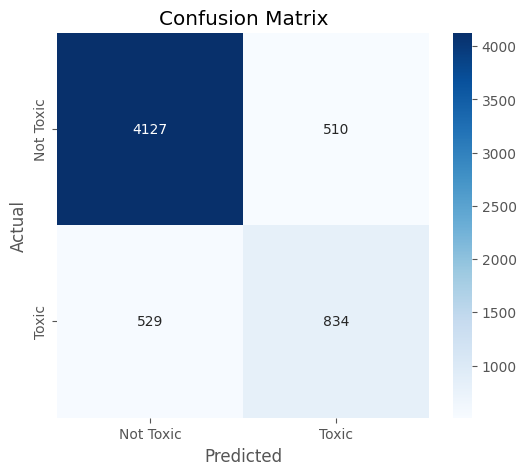

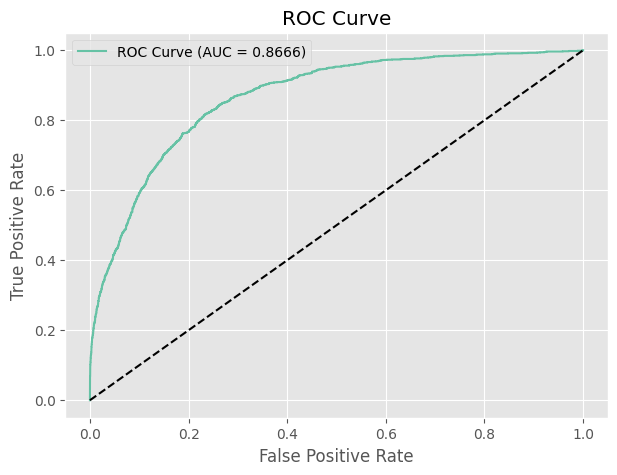

In [43]:
# Predict probabilities
y_proba = model.predict(test_ds)[:, 0]  # get the toxic column only (index 0)

# True labels (toxic column only)
y_true = y_test.values

# Using different thresholds to find the best one
thresholds = [i * 0.05 for i in range(1, 21)]  # 0.05 to 1.0
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    
    # Computing F1 separately to select best threshold
    f1 = f1_score(y_true, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1:.4f}\n")

# Final prediction using best threshold
y_pred = (y_proba >= best_threshold).astype(int)

evaluate_model(y_true, y_pred, y_proba)